# 15. Daily Closing Stock Price compared to US GDP price
Hypothesis: I believe there will be a significant relationship between daily closing stock price and the quarterly US real GDP per capita.

Conclusion: The pearson r correlation is 0.99 showing a very high correlation between the two variables, showing the hypothesis is true.

In [16]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress
from pprint import pprint
import yfinance as yf
import calendar
from datetime import datetime

# Import the API key
from api_keys import fred_api_key

# Getting Daily stock close price compared to US Real GDP Quarterly
Daily closing Stock price and US Real GDP per Capita (y-axis : scaling 0 ~ 1), Quarterly (x-axis) for 10 years by line plot (Bailey)


### Step 1: US Real GDP per Capita
Using "A939RX0Q048SBEA" on FRED as it seems pretty accurate

In [17]:

# FRED API url assembly
url = "https://api.stlouisfed.org/fred/series/observations"
params = {
    "series_id": "A939RX0Q048SBEA",  # Interest rate series ID
    "api_key": fred_api_key,  # Replace with your API key
    "file_type": "json",
    "observation_start": "2010-01-01", # Starting year of data gathering
    "observation_end": "2019-12-31" 
}
# Make the response, ensure that you've added your API key for FRED in the api_keys.py file else this request will not work
# Please also note that FRED has a limited number of requests per day so only run this cell a few times
response = requests.get(url, params=params)
GDP_Data = response.json()

### Step 2: Get stock data
Using Common_Module we import the stockdata dataframe

In [18]:
from Common_Module.Common_Stockdata import get_stock_data
stock = get_stock_data()
stock[["Date", "Close"]].sort_values(by=["Date"])

,Date,Close
3606,2010-01-04,46.42
3605,2010-01-05,46.42
3604,2010-01-06,46.14
3603,2010-01-07,46.17
3602,2010-01-08,46.55
...,...,...
1095,2019-12-24,211.92
1094,2019-12-26,213.79
1093,2019-12-27,213.61
1092,2019-12-30,212.21


### Step 3: turn into GDP Dataframe
Turn the raw json data from FRED into a Dataframe that can be organised easier

In [19]:
datatotal = 0
updated_date = []
updated_rate = [] # assigned variables outside forloop with empty variables ready to be appended
# For loop will take the date and rate from the json file for the 10 years requested and add the values to a new array
for observation in GDP_Data["observations"]:
    date = observation["date"]
    interest_rate = observation["value"]
    updated_date.append(date)
    updated_rate.append(interest_rate)
    datatotal = datatotal + 1

daily_GDP_df = pd.DataFrame({
    "Date" : updated_date,
    "GDP Amount" : updated_rate
    })
daily_GDP_df.replace('.', pd.NA, inplace=True)  # Use pd.NA for missing values in newer versions of Pandas
daily_GDP_df.dropna(inplace=True) # Dropping any nulls based on '.'
daily_GDP_df.reset_index()
print()

### Step 4: Convert into one dataframe
Now we get both of these frames and combine them based on the DATE column

In [20]:
stock['Date'] = pd.to_datetime(stock['Date'])
daily_GDP_df['Date'] = pd.to_datetime(daily_GDP_df['Date'])

# Merge using pd.merge_asof()
merged_GDP_df = pd.merge_asof(stock.sort_values('Date'), daily_GDP_df, on='Date', direction='backward')

# Fill NaN values in GDP columns with the last valid observation
gdp_columns = [col for col in merged_GDP_df.columns if 'GDP' in col]
merged_GDP_df[gdp_columns] = merged_GDP_df[gdp_columns].fillna(method='ffill')

# Drop NaN values
merged_GDP_df.dropna(inplace=True)

C:\Users\baile\AppData\Local\Temp\ipykernel_3000\3236997414.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_GDP_df[gdp_columns] = merged_GDP_df[gdp_columns].fillna(method='ffill')


### Step 5: Dataframe organising 
Sort all the data and arrange it into lists and arrays to be used in the Line Graph

In [21]:
close_list = merged_GDP_df["Close"].tolist()
close_list_float = [float(val) for val in close_list]
close_array = np.array(close_list_float)

close_list_min = close_array.min()
close_list_max = close_array.max()

close_list_float_normalised = (close_array - close_list_min) / (close_list_max - close_list_min)
close_list_float_normalised

GDP_list = merged_GDP_df['GDP Amount'].tolist()
GDP_list_float = [float(val) for val in GDP_list]
GDP_array = np.array(GDP_list_float)

GDP_list_min = GDP_array.min()
GDP_list_max = GDP_array.max()
GDP_list_float_normalised = (GDP_array - GDP_list_min) / (GDP_list_max - GDP_list_min)

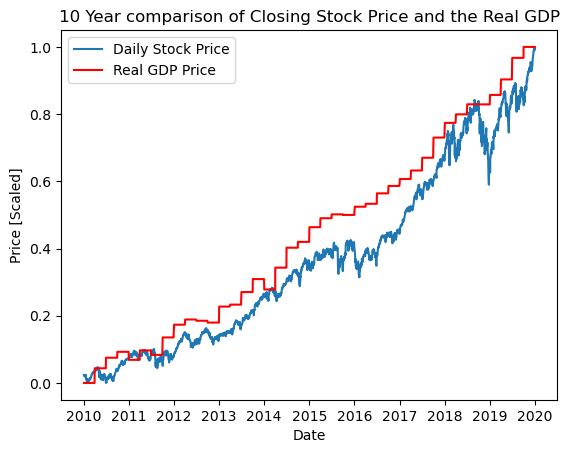

In [22]:
# Graphing the plot
plt.plot(merged_GDP_df['Date'], close_list_float_normalised, label='Daily Stock Price')
plt.plot(merged_GDP_df['Date'], GDP_list_float_normalised, label='Real GDP Price', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price [Scaled]')
plt.title('10 Year comparison of Closing Stock Price and the Real GDP')
plt.savefig("output_data/DailyClose_vs_RealGDP.png")

In [23]:
correlation = st.pearsonr(GDP_list_float_normalised, close_list_float_normalised)
print(f"The correlation between these variables is: {round(correlation[0],2)}")

The correlation between these variables is: 0.99
